In [1]:
%reload_ext autoreload
%autoreload 2


# Make a simple atom

In [2]:
from atomphys.quantum_numbers import QuantumNumbers

QuantumNumbers.from_term("1D2")

QuantumNumbers(J=2, L=2, S=0, parity=1)

In [3]:
from math import pi
from atomphys import State, Transition, Atom
from pint import get_application_registry

from atomphys.plot import plot_atom


ureg = get_application_registry()

# ------- two levels

s_s = State(configuration='1s', term="1S0", energy=0)
s_p = State('2p', '1P1', energy=ureg('400 nm').to('Ry'))

tr_sp = Transition(state_i=s_s, state_f=s_p, A=1 / ureg('1 ns') / 2 / pi)

a2 = Atom('Simple_two_levels')
a2.add_states([s_s, s_p])
a2.add_transition(tr_sp)

del s_s, s_p, tr_sp

# ------- three levels
# I cannot recycle states otherwise it would overwrite their ._atom

s_s = State(configuration='1s', term="1S0", energy=0)
s_p = State('2p', '1P1', energy=ureg('400 nm').to('Ry'))
s_d = State('3d', '1D2', energy=ureg('600 nm').to('Ry'))

tr_sp = Transition(state_i=s_s, state_f=s_p, A=1 / ureg('1 ns') / 2 / pi)
tr_sd = Transition(s_s, s_d, A=1 / ureg('1 s') / 2 / pi)
tr_dp = Transition(s_d, s_p, A=1 / ureg('10 ns') / 2 / pi)

a3 = Atom('Simple_three_levels')
a3.add_states([s_s, s_p, s_d])
a3.add_transitions([tr_sp, tr_sd, tr_dp])

del s_s, s_p, s_d, tr_sp, tr_sd, tr_dp


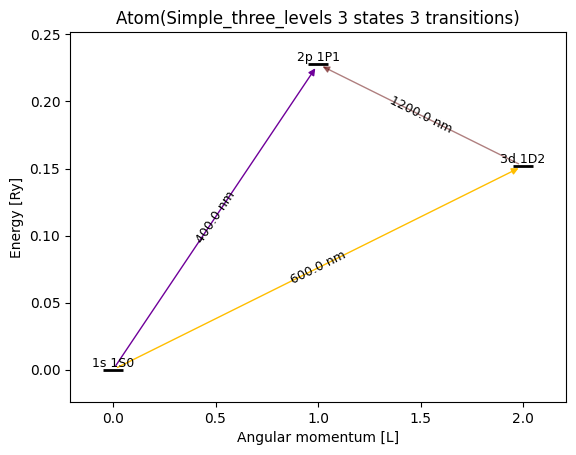

In [4]:
plot_atom(a3)

In [5]:
a2.states[0] == a3.states[0], a2.states[0] is a3.states[0]

(True, False)

# Make hamiltonians

In [6]:
from atomphys.calc import Hamiltonians as hat
from atomphys.electric_field import LaserField
import pint
import qutip
import numpy as np
import matplotlib.pyplot as plt

ureg = pint.get_application_registry()
ureg.default_format = ".4f~P"


## Decay of excited state

In [7]:
atom = a3

kets = hat.kets(atom, atom.states)
H0 = hat.H0(atom, atom.states, None)
c_ops = hat.collapse_operators(atom, atom.states, atom._ureg, print_added_operators=True)

# projectors = {ss: ket * ket.dag() for ss, ket in kets.items()}
projectors = {}
for s in atom.states:
    proj = sum([ket * ket.dag() for (_s, _), ket in kets.items() if _s == s])
    projectors[s] = proj
    
e_ops = list(projectors.values())


Added 1.59×10⁻⁷+0j MHz c operator from ('1D2', -2.0) to ('1S0', 0.0)
Added 1.59×10⁻⁷+0j MHz c operator from ('1D2', -1.0) to ('1S0', 0.0)
Added 1.59×10⁻⁷+0j MHz c operator from ('1D2', 0.0) to ('1S0', 0.0)
Added 1.59×10⁻⁷+0j MHz c operator from ('1D2', 1.0) to ('1S0', 0.0)
Added 1.59×10⁻⁷+0j MHz c operator from ('1D2', 2.0) to ('1S0', 0.0)
Added 159+0j MHz c operator from ('1P1', -1.0) to ('1S0', 0.0)
Added 159+0j MHz c operator from ('1P1', 0.0) to ('1S0', 0.0)
Added 159+0j MHz c operator from ('1P1', 1.0) to ('1S0', 0.0)
Added 9.55+0j MHz c operator from ('1P1', -1.0) to ('1D2', -2.0)
Added 0+0j MHz c operator from ('1P1', 0.0) to ('1D2', -2.0)
Added 0+0j MHz c operator from ('1P1', 1.0) to ('1D2', -2.0)
Added 4.77+0j MHz c operator from ('1P1', -1.0) to ('1D2', -1.0)
Added 4.77+0j MHz c operator from ('1P1', 0.0) to ('1D2', -1.0)
Added 0+0j MHz c operator from ('1P1', 1.0) to ('1D2', -1.0)
Added 1.59+0j MHz c operator from ('1P1', -1.0) to ('1D2', 0.0)
Added 6.37+0j MHz c operator f

In [8]:
H0

Quantum object: dims = [[9], [9]], shape = (9, 9), type = oper, isherm = True
Qobj data =
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 3.13941928e+09 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 3.13941928e+09 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.13941928e+09
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  3.13941928e+09 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 3.13941928e+09 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e

In [9]:
psi0 = kets[(atom.get_state("P"), -1)]
t = np.arange(0, 0.1, 0.0005)

sol = qutip.mesolve(H0, psi0, t, c_ops, e_ops, progress_bar=True)


10.0%. Run time:   0.00s. Est. time left: 00:00:00:00
20.0%. Run time:   0.00s. Est. time left: 00:00:00:00
30.0%. Run time:   0.02s. Est. time left: 00:00:00:00
40.0%. Run time:   0.02s. Est. time left: 00:00:00:00
50.0%. Run time:   0.02s. Est. time left: 00:00:00:00
60.0%. Run time:   0.02s. Est. time left: 00:00:00:00
70.0%. Run time:   0.02s. Est. time left: 00:00:00:00
80.0%. Run time:   0.02s. Est. time left: 00:00:00:00
90.0%. Run time:   0.02s. Est. time left: 00:00:00:00
Total run time:   0.02s


In [10]:
# populations = {k: np.real(np.diag(s)) for k, s in zip(kets.keys(), sol.states)}
populations = np.asarray(sol.expect).T
populations.shape


(200, 3)

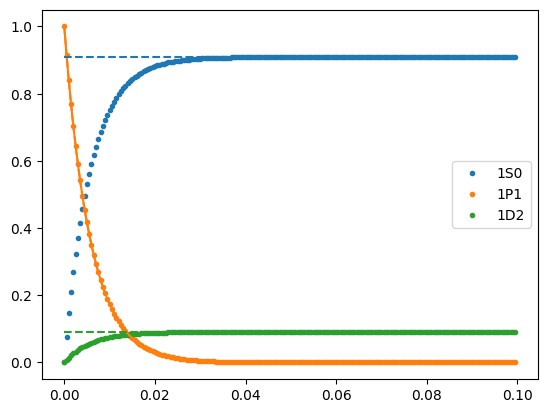

In [11]:
# ------- fit decay and check final populations

from scipy.optimize import curve_fit


def decay(t, tau):
    return np.exp(-t / tau)


expected_tau = 1 / atom.get_state('P').Gamma


p, cov = curve_fit(decay, t, populations[:, 1], (1,))
fitted_tau = p[0] * ureg.us

fig, ax = plt.subplots()
ax.plot(t, populations, 'o', ms=3, label=[s.term for s in projectors.keys()])
ax.plot(t, decay(t, *p), 'C1')
ax.plot(t, decay(t, expected_tau.to('us').m), 'C1--')

ax.hlines(atom.get_state('P').decay_branching_ratios.values(), t[0], t[-1], color=['C0', 'C2'], ls='--')
ax.legend()

In [12]:


print(expected_tau.to('ns'))
print(fitted_tau.to('ns'))


5.7120 ns
5.7120 ns


In [13]:
populations[-1]

array([9.09090822e-01, 9.68185646e-08, 9.09090808e-02])

In [14]:
atom.states[1].Gamma.to('MHz')

175.0704374010848 <Unit('megahertz')>

In [15]:
atom.states

[State(1s 1S0 0 Ry), State(2p 1P1 0.2278 Ry), State(3d 1D2 0.1519 Ry)]

# Rabi oscilations

In [16]:
# eps = (1, 1j, 0)
# e_z = (0, 0, 1)
eps = (0, 0, 1)
e_z = (1, 0, 0)
# P = 1 * ureg('uW')
# waist = 50 * ureg('um')
# I0 = 2 * P / (np.pi * waist**2)

atom = a2
tr = atom.transitions[0]
I0 = tr.saturation_intensity

laser = LaserField(polarization=eps, direction_of_propagation=e_z, wavelength=tr.wavelength, intensity=I0, detuning=0)

lasers = {laser: [tr]}
states = atom.states
kets = hat.kets(atom, states)
H = hat.H0(atom, states, None) + hat.H_int(atom, states, lasers, None)
projectors = {ss: ket * ket.dag() for ss, ket in kets.items()}
e_ops = list(projectors.values())


H

Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0.00000000e+00 0.00000000e+00 5.62697698e+01 0.00000000e+00]
 [0.00000000e+00 9.53674316e-07 0.00000000e+00 0.00000000e+00]
 [5.62697698e+01 0.00000000e+00 9.53674316e-07 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 9.53674316e-07]]

In [17]:
psi0 = kets[(atom.get_state("S"), 0)]
t = np.arange(0, 0.2, 0.002)

sol = qutip.mesolve(H, psi0, t, c_ops=None, e_ops=e_ops, progress_bar=True)


10.0%. Run time:   0.00s. Est. time left: 00:00:00:00
20.0%. Run time:   0.00s. Est. time left: 00:00:00:00
30.0%. Run time:   0.02s. Est. time left: 00:00:00:00
40.0%. Run time:   0.02s. Est. time left: 00:00:00:00
50.0%. Run time:   0.02s. Est. time left: 00:00:00:00
60.0%. Run time:   0.02s. Est. time left: 00:00:00:00
70.0%. Run time:   0.03s. Est. time left: 00:00:00:00
80.0%. Run time:   0.03s. Est. time left: 00:00:00:00
90.0%. Run time:   0.04s. Est. time left: 00:00:00:00
Total run time:   0.04s


In [18]:
populations = np.asarray(sol.expect).T
populations.shape


(100, 4)

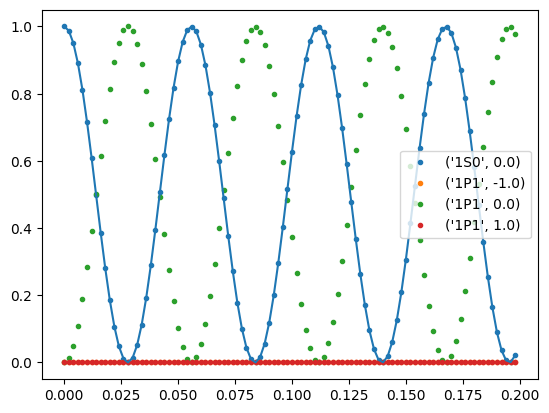

In [19]:
# ------- fit flop

from scipy.optimize import curve_fit


def flop(t, rabi_freq):
    return 0.5 + 0.5 * np.cos(2*np.pi*rabi_freq*t)



p, cov = curve_fit(flop, t, populations[:, 0], (15,))
fitted_rabi_freq = p[0] * ureg('MHz')

fig, ax = plt.subplots()
ax.plot(t, populations, 'o', ms=3, label=[(s.term, m) for s, m in projectors.keys()])
ax.plot(t, flop(t, *p), 'C0')

ax.legend()

In [20]:
from atomphys.calc.rabi_frequency import Rabi_Frequency

calculated_rabi_freq = abs(float(Rabi_Frequency(laser, tr, mJ_i=0, mJ_f=0).to("MHz").m)) * ureg("MHz") / 2 / pi
calculated_rabi_freq

C:\Users\carmelo\AppData\Local\Temp\ipykernel_3344\962790346.py:3: ComplexWarning: Casting complex values to real discards the imaginary part
  calculated_rabi_freq = abs(float(Rabi_Frequency(laser, tr, mJ_i=0, mJ_f=0).to("MHz").m)) * ureg("MHz") / 2 / pi


17.911224007836125 <Unit('megahertz')>

In [21]:
expected_rabi_freq_isat = tr.Gamma.to("MHz") / np.sqrt(2) / 2 / pi
expected_rabi_freq_isat


17.91122400783613 <Unit('megahertz')>

In [22]:
fitted_rabi_freq

17.91119897481327 <Unit('megahertz')>

In [23]:
laser.intensity

51.73036086325333 <Unit('milliwatt / centimeter ** 2')>

# Raman

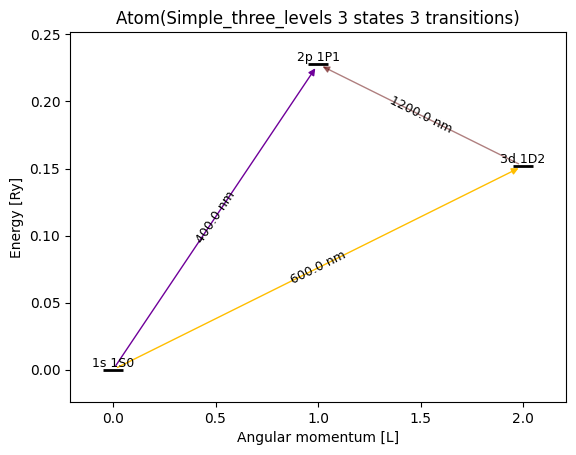

In [24]:
from atomphys import plot_atom

plot_atom(a3)

In [67]:
from atomphys.calc.rabi_frequency import electric_field_from_pi_dipole_rabi_frequency

from atomphys.electric_field import PlaneWaveElectricField


def intensity_from_e_field(E0):
    return (E0**2 * ureg("c*epsilon_0") / 2).to("mW/cm^2")


estimate the raman Rabi frequency

In [142]:

rabi_freq = ureg('100 MHz')
Delta = ureg('10 GHz')
raman_rabi = (rabi_freq**2 / 2 / Delta).to("MHz")
raman_rabi


0.5000000000000001 <Unit('megahertz')>

In [146]:
Delta / atom.states[1].Gamma.to("MHz")

57.119866428905354 <Unit('dimensionless')>

In [149]:
atom.states[1].Gamma


27.86332550164288 <Unit('_2pi * megahertz')>

In [143]:
spont_scatt = (rabi_freq / Delta)**2
print(f"{spont_scatt:.3e~P}")

1.000×10⁻⁴


In [116]:
tr = a3.transitions[0]
e_field = electric_field_from_pi_dipole_rabi_frequency(rabi_freq * 2 * np.pi, tr.A, tr.k, J_i=0, _ureg=ureg)

e_field

3485.6017901198243 <Unit('volt / meter')>

In [117]:
_int = intensity_from_e_field(e_field)
_int

1612.4823777761426 <Unit('milliwatt / centimeter ** 2')>

In [119]:
_waist = ureg('4 um')
_pow = (_int * 0.5 * np.pi * _waist**2).to("uW")
_pow

0.40526102336516245 <Unit('microwatt')>

In [120]:
atom = a3
atom.transitions

[Transition(1s 1S0 --> 2p 1P1 400.0 nm (E1)),
 Transition(1s 1S0 --> 3d 1D2 600.0 nm (E2)),
 Transition(3d 1D2 --> 2p 1P1 1200.0 nm (E1))]

In [121]:
eps = (1, 1j, 0)
e_z = (0, 0, 1)


# f1 = ureg('410 nm').to('THz')
f1 = atom.get_state('P').energy.to('THz') - Delta
f2 = f1 - atom.get_state('D').energy.to('THz')

print(Delta.to("MHz"))
print((rabi_freq**2 / 4 / Delta).to("MHz"))

delta = 0. * ureg.MHz


pw_efield1 = PlaneWaveElectricField(e_field, polarization=eps, wavevector=e_z, frequency=f1 + delta)
pw_efield2 = PlaneWaveElectricField(e_field, polarization=eps, wavevector=e_z, frequency=f2)


fields = {
    pw_efield1: [atom.transitions[0]],
    pw_efield2: [atom.transitions[2]],
}
states = atom.states
kets = hat.kets(atom, states)
H = hat.H0(atom, states, None) + hat.H_int(atom, states, fields, None)
projectors = {ss: ket * ket.dag() for ss, ket in kets.items()}
e_ops = list(projectors.values())

# c_ops = hat.collapse_operators(atom, states, atom._ureg)



H


10000.0000 MHz
0.2500 MHz


Quantum object: dims = [[9], [9]], shape = (9, 9), type = oper, isherm = True
Qobj data =
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  3.14159265e+02]
 [0.00000000e+00 4.76837158e-07 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 3.99859464e+02 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 4.76837158e-07 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 2.82743339e+02
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 4.76837158e-07
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.63241943e+02]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  4.76837158e-07 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 4.76837158e-07 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 3.99859464e+02 0.00000000e+00 0.00000000e

In [131]:
psi0 = kets[(atom.get_state("S"), 0)]
t = np.arange(0, 6, 0.002)

sol = qutip.mesolve(H, psi0, t, c_ops=None, e_ops=e_ops, progress_bar=True)#, options=qutip.Options(nsteps=1e7))


10.0%. Run time:   1.14s. Est. time left: 00:00:00:10
20.0%. Run time:   1.91s. Est. time left: 00:00:00:07
30.0%. Run time:   2.36s. Est. time left: 00:00:00:05
40.0%. Run time:   2.87s. Est. time left: 00:00:00:04
50.0%. Run time:   3.51s. Est. time left: 00:00:00:03
60.0%. Run time:   3.95s. Est. time left: 00:00:00:02
70.0%. Run time:   4.42s. Est. time left: 00:00:00:01
80.0%. Run time:   4.92s. Est. time left: 00:00:00:01
90.0%. Run time:   5.56s. Est. time left: 00:00:00:00
Total run time:   6.27s


In [132]:
populations = np.asarray(sol.expect).T
populations.shape


(3000, 9)

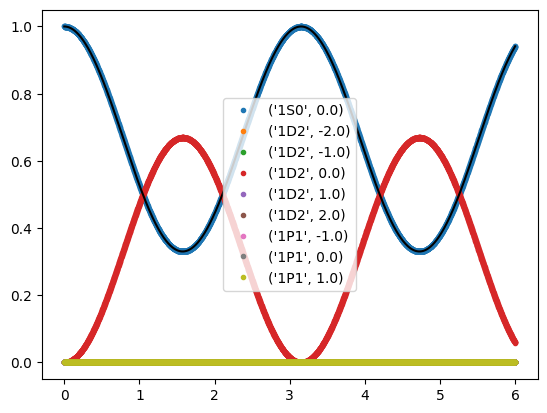

In [133]:
# ------- fit flop

from scipy.optimize import curve_fit


def flop(t, rabi_freq, detuning):
    r2 = np.hypot(rabi_freq, detuning)
    return 1 - rabi_freq**2 / (r2**2) * np.sin(np.pi * r2 * t)**2


y = populations[:, 0]
p, cov = curve_fit(flop, t, y, (0.3, 0.3))
fitted_rabi_freq = p[0] * ureg('MHz')
fitted_detuning = p[1] * ureg('MHz')

fig, ax = plt.subplots()
ax.plot(t, populations, 'o', ms=3, label=[(s.term, m) for s, m in projectors.keys()])
ax.plot(t, flop(t, *p), 'k')

ax.legend()


In [134]:
fitted_rabi_freq, fitted_detuning

(0.25980515895325734 <Unit('megahertz')>,
 0.1824856954561876 <Unit('megahertz')>)

In [135]:
omega1 = Rabi_Frequency(pw_efield1, atom.transitions[0], 0, 1) / 2 / np.pi

omega1


(-99.99999999999999+0j) <Unit('megahertz')>

In [136]:
omega2 = Rabi_Frequency(pw_efield2, atom.transitions[2], 0, 1) / 2 / np.pi

omega2


(-51.96152422706633+0j) <Unit('megahertz')>

In [137]:
(omega1 * omega2 / 2 / Delta).to("MHz").real

0.2598076211353316 <Unit('megahertz')>

In [138]:
((omega1**2 - omega2**2) / 4 / Delta).to("MHz").real


0.18249999999999988 <Unit('megahertz')>

In [139]:
from atomphys.calc.ac_stark import AC_stark_shift

ac1 = AC_stark_shift(atom.states[0], mJ=0, El_field=pw_efield1, _ureg=ureg).real
ac1.to("MHz")


-0.2500016678315012 <Unit('megahertz')>

In [140]:
ac2 = AC_stark_shift(atom.states[2], mJ=0, El_field=pw_efield2, _ureg=ureg).real
ac2.to("MHz")


-0.06750135096162352 <Unit('megahertz')>

In [141]:

(ac2 - ac1).to("MHz")

0.18250031686987767 <Unit('megahertz')>